In [1]:
import os
import sys

if 'has_changed_dir' not in globals():
    repo_path = os.path.abspath(os.path.join('..'))
    
    if repo_path not in sys.path:
        sys.path.append(repo_path)
    
    os.chdir(repo_path)
    
    globals()['has_changed_dir'] = True

import numpy as np
from tqdm import tqdm

import neunet as nnet
import neunet.nn as nn
import matplotlib.pyplot as plt
from neunet.optim import Adam

In [2]:
device = "cpu"

document = [
    "Nice Clothes!",
    "Very good shop for clothes",
    "Amazing clothes",
    "Clothes are good",
    "Superb!",
    "Very bad",
    "Poor quality",
    "not good",
    "clothes fitting bad",
    "Shop not good",
]

labels = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
vocab_size = 40


chars2remove = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

In [3]:
filtered_document: list[str] = []
for line in document:
    line = "".join([c for c in line if c not in chars2remove])
    filtered_document.append(line)

print(f"Filtered document: {filtered_document}")

words = {word.lower() for line in filtered_document for word in line.split()}

print(f"Words: {words}")

words_labels = np.random.choice(range(1, vocab_size), len(words), replace=False)
vocab = dict(zip(words, words_labels, strict=False))

encoded_document: list[list[int]] = []
for line in filtered_document:
    encoded_line: list[int] = []
    for word in line.split():
        encoded_line.append(vocab[word.lower()])
    encoded_document.append(encoded_line)

print(f"Encoded document: {encoded_document}")

max_length = len(max(encoded_document, key=len))
print(f"Max length: {max_length}")

padded_document: list[list[int]] = []
for encoded_line in encoded_document:
    if len(encoded_line) < max_length:
        padded_line = encoded_line + [0] * (max_length - len(encoded_line))
    padded_document.append(padded_line)

print("Padded document:", *padded_document, sep="\n")


Filtered document: ['Nice Clothes', 'Very good shop for clothes', 'Amazing clothes', 'Clothes are good', 'Superb', 'Very bad', 'Poor quality', 'not good', 'clothes fitting bad', 'Shop not good']
Words: {'amazing', 'are', 'bad', 'nice', 'quality', 'superb', 'fitting', 'not', 'clothes', 'very', 'poor', 'good', 'for', 'shop'}
Encoded document: [[37, 12], [2, 1, 38, 18, 12], [16, 12], [12, 3, 1], [7], [2, 35], [11, 13], [25, 1], [12, 29, 35], [38, 25, 1]]
Max length: 5
Padded document:
[37, 12, 0, 0, 0]
[37, 12, 0, 0, 0]
[16, 12, 0, 0, 0]
[12, 3, 1, 0, 0]
[7, 0, 0, 0, 0]
[2, 35, 0, 0, 0]
[11, 13, 0, 0, 0]
[25, 1, 0, 0, 0]
[12, 29, 35, 0, 0]
[38, 25, 1, 0, 0]


In [4]:

# class ExtractTensor(nn.Module):
#     def __init__(self, return_sequences):
#         super().__init__()
#         self.return_sequences = return_sequences

#     def forward(self, X):
#         all_states, last_state = X
#         if self.return_sequences:
#             return all_states
#         else:
#             return last_state

# model = nn.Sequential(
#     nn.Embedding(vocab_size, 10),
#     nn.GRU(10, 50),
#     ExtractTensor(return_sequences=True),
#     nn.GRU(50, 50),
#     ExtractTensor(return_sequences=True),
#     nn.GRU(50, 50),
#     ExtractTensor(return_sequences=False),
#     nn.Linear(50, 1),
#     nn.Sigmoid()
# )

model = nn.Sequential(
    nn.Embedding(vocab_size, 10),
    nn.Bidirectional(nn.GRU(10, 50, return_sequences=True), merge_mode="sum"),
    nn.Bidirectional(nn.RNN(50, 50, return_sequences=True, bias=True)),
    nn.Bidirectional(nn.GRU(50, 50, return_sequences=False)),
    nn.Linear(50, 1),
    nn.Sigmoid(),
).to(device)


loss_fn = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [5]:
array_padded_document: np.ndarray = np.array(padded_document)
labels = nnet.tensor(np.array(labels).reshape(-1, 1), device=device)

In [6]:
loss = []
epochs = 100
tqdm_range = tqdm(range(epochs))
for epoch in tqdm_range:
    for i in range(array_padded_document.shape[0]):
        optimizer.zero_grad()
        y_pred = model.forward(nnet.tensor(array_padded_document[i], dtype=nnet.int32).to(device))

        loss_ = loss_fn(y_pred, labels[i])
        loss_.backward()
        optimizer.step()
        loss.append(loss_.item())

    tqdm_range.set_description(f"epoch: {epoch + 1}/{epochs}, loss: {loss[-1]:.7f}")

epoch: 100/100, loss: 0.0000029: 100%|██████████| 100/100 [00:05<00:00, 17.99it/s]


In [7]:
acc = 0
for i in range(array_padded_document.shape[0]):
    y_pred = model.forward(nnet.tensor(array_padded_document[i], dtype=nnet.int32))
    if y_pred.detach().cpu().numpy().round() == labels[i]:
        acc += 1

print(f"Accuracy: {acc / array_padded_document.shape[0] * 100}%")


Accuracy: 100.0%


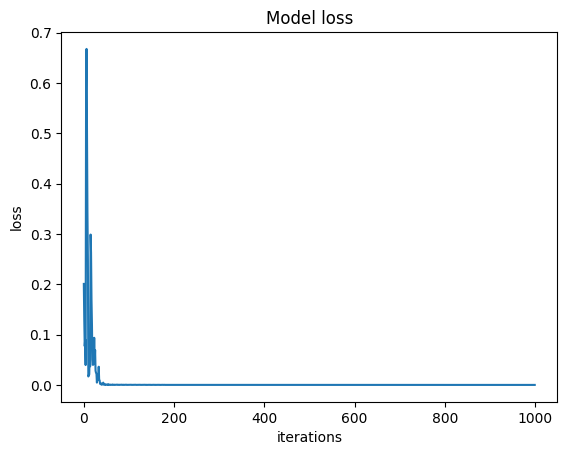

In [8]:
plt.plot(loss)
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("iterations")
plt.show()
